In [ ]:
import cv2
import numpy as np
from itertools import product

In [ ]:
data_dir = "dinoSparseRing/"
file_base = "dinoSR"
T = 20

In [ ]:
!unzip dinoSparseRing.zip

Archive:  dinoSparseRing.zip
   creating: dinoSparseRing/
  inflating: __MACOSX/._dinoSparseRing  
  inflating: dinoSparseRing/dinoSR0015.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0015.png  
  inflating: dinoSparseRing/dinoSR0001.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0001.png  
  inflating: dinoSparseRing/Thumbs.db  
  inflating: __MACOSX/dinoSparseRing/._Thumbs.db  
  inflating: dinoSparseRing/dinoSR0014.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0014.png  
  inflating: dinoSparseRing/dinoSR0002.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0002.png  
  inflating: dinoSparseRing/dinoSR0016.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0016.png  
  inflating: dinoSparseRing/dinoSR0003.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0003.png  
  inflating: dinoSparseRing/dinoSR0007.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0007.png  
  inflating: dinoSparseRing/dinoSR0013.png  
  inflating: __MACOSX/dinoSparseRing/._dinoSR0013.png  
  

# Reading Images and Camera Parameters

In [ ]:
# Reading the camera parameters from 'dinoSR_par.txt'
with open(data_dir + "/" + file_base + "_par.txt", 'r') as f:
  lines = f.readlines() 

  M = []
  for l in lines[1:]: 
    tmp = np.array(l.strip().split(" ")[1:]).astype(np.float32)
    K = tmp[0:9].reshape((3, 3))
    R = tmp[9:18].reshape((3, 3))
    t = tmp[18:].reshape((3, 1))
    M.append(np.matmul(K, np.concatenate([R, t], axis=1)))

  N = len(lines) - 1

In [ ]:
# Reading images
imgs = []
for i in range(N):
  im = cv2.imread(data_dir + "/" + file_base + f'{i + 1:04}' + ".png")
  imgs.append(np.array(im))
imgs = np.array(imgs)

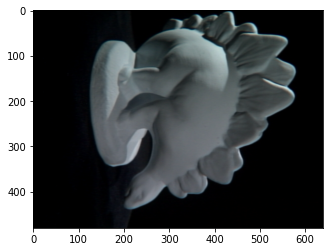

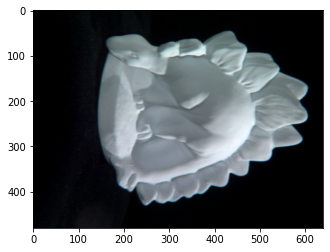

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(imgs[10])

In [ ]:
# Thresholding images for masking
silhouettes = []
for im in imgs:
  ch1 = im[:, :, 0] > T
  ch2 = im[:, :, 1] > T
  ch3 = im[:, :, 2] > T
  silhouettes.append((ch1 + ch2 + ch3) > 0)
silhouettes = np.array(silhouettes).transpose(1, 2, 0)

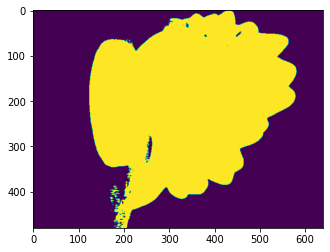

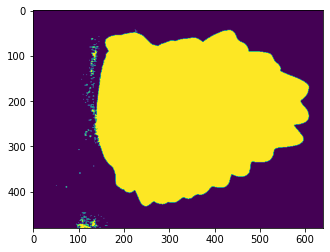

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(silhouettes[:, :, 0])
plt.figure()
plt.imshow(silhouettes[:, :, 10])

# Visual Hull

In [ ]:
# Define a voxel grid which has the 3D locations of each voxel which can then be projected onto each image
def InitializeVoxels(xlim, ylim, zlim, voxel_size):
  voxels_number = [1, 1, 1]
  voxels_number[0] = np.abs(xlim[1]-xlim[0]) / voxel_size[0]
  voxels_number[1] = np.abs(ylim[1]-ylim[0]) / voxel_size[1]
  voxels_number[2] = np.abs(zlim[1]-zlim[0]) / voxel_size[2]
  voxels_number_act = np.array(voxels_number).astype(int) + 1
  total_number = np.prod(voxels_number_act)

  voxel = np.ones((np.int(total_number), 4))

  sx = xlim[0]
  ex = xlim[1]
  sy = ylim[0]
  ey = ylim[1]
  sz = zlim[0]
  ez = zlim[1]

  if(ex > sx):
    x_step = voxel_size[0];
  else:
    x_step = -voxel_size[0];

  if(ey > sy):
    y_step = voxel_size[1];
  else:
    y_step = -voxel_size[1];

  if(sz > ez):
    z_step = voxel_size[2];
  else:
    z_step = -voxel_size[2];

  voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(np.linspace(sx, ex, voxels_number_act[0]), 
                                             np.linspace(sy, ey, voxels_number_act[1]),
                                             np.linspace(ez, sz, voxels_number_act[2]))
  
  l = 0;
  for z in np.linspace(ez, sz, voxels_number_act[2]):
    for x in np.linspace(sx, ex, voxels_number_act[0]):
      for y in np.linspace(sy, ey, voxels_number_act[1]):
        voxel[l] = [x, y, z, 1] 
        l=l+1

  return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number

In [ ]:
voxel_size = [0.001, 0.001, 0.001] # size of each voxel

# The dimension limits
xlim = [-0.07, 0.02]
ylim = [-0.02, 0.07]
zlim = [-0.07, 0.02]

voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size);

In [ ]:
print(voxels.shape)

(753571, 4)


In [ ]:
print(voxels) # The first three values are the x-y-z-coordinates of the voxel, the fourth value is a dummy variable which we will use later on

[[-0.07  -0.02   0.02   1.   ]
 [-0.07  -0.019  0.02   1.   ]
 [-0.07  -0.018  0.02   1.   ]
 ...
 [ 0.02   0.068 -0.07   1.   ]
 [ 0.02   0.069 -0.07   1.   ]
 [ 0.02   0.07  -0.07   1.   ]]


In [ ]:
object_points3D = np.copy(voxels).T
voxels[:, 3] = 0 # making the fourth variable of each voxel 0

proj = []

for i in range(N):

  # CAMERA PARAMETERS
  M_ = M[i]

  # PROJECTION TO THE IMAGE PLANE
  points2D = np.matmul(M_, object_points3D)
  points2D = np.floor(points2D / points2D[2, :]).astype(np.int32)
  points2D[np.where(points2D < 0)] = 0; # check for negative image coordinates

  img_size = (silhouettes).shape
  ind1 = np.where(points2D[1, :] >= img_size[0]) # check for out-of-bounds (width) coordinate
  points2D[:, ind1] = 0
  ind1 = np.where(points2D[0, :] >= img_size[1]) # check for out-of-bounds (height) coordinate
  points2D[:, ind1] = 0

  # ACCUMULATE THE VALUE OF EACH VOXEL IN THE CURRENT IMAGE
  voxels[:, 3] += silhouettes[:, :, i].T[points2D.T[:, 0], points2D.T[:, 1]]

  proj.append(points2D)

In [ ]:
print(voxels) # the fourth value is the number of image views (out of N total) which contain this voxel in the object mask

[[-0.07  -0.02   0.02   5.   ]
 [-0.07  -0.019  0.02   5.   ]
 [-0.07  -0.018  0.02   4.   ]
 ...
 [ 0.02   0.068 -0.07   2.   ]
 [ 0.02   0.069 -0.07   2.   ]
 [ 0.02   0.07  -0.07   2.   ]]


In [ ]:
def ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxel):
  sx = -(voxels_number[0] / 2) * voxel_size[0]
  ex = voxels_number[0] / 2 * voxel_size[0]

  sy = -(voxels_number[1] / 2) * voxel_size[1]
  ey = voxels_number[1] / 2 * voxel_size[1]
  sz = 0;
  ez = voxels_number[2] * voxel_size[2]
  voxels_number = np.array(voxels_number).astype(np.int32)
  voxel3D = np.zeros((voxels_number[1] + 1, voxels_number[0] + 1, voxels_number[2] + 1));

  l = 0
  z1 = 0
  for z in np.arange(ez, sz, -voxel_size[2]):
      x1 = 0
      for x in np.arange(sx, ex, voxel_size[0]):
          y1 = 0
          for y in np.arange(sy, ey, voxel_size[1]):
              voxel3D[y1, x1, z1] = voxel[l, 3]
              l = l + 1
              y1 = y1 + 1
          x1 = x1 + 1
      z1 = z1 + 1

  return voxel3D

In [ ]:
error_amount = 5
maxv = np.max(voxels[:, 3])
iso_value = maxv-np.round(((maxv)/100)*error_amount)-0.5
print('max number of votes:' + str(maxv))
print('threshold for marching cube:' + str(iso_value))

voxel3D = ConvertVoxelList2Voxel3D(np.array(voxels_number), voxel_size, voxels)

max number of votes:16.0
threshold for marching cube:14.5


# Marching Cubes

In [ ]:
!pip install --upgrade PyMCubes
!pip install pycollada

Requirement already up-to-date: PyMCubes in /usr/local/lib/python3.6/dist-packages (0.1.2)
     |████████████████████████████████| 112kB 2.8MB/s 
  Created wheel for pycollada: filename=pycollada-0.7.1-cp36-none-any.whl size=125610 sha256=ec1d156052e30cbffbff288a851aa76b54eb30d94e3a6130e29e9bd8253dc71e
  Stored in directory: /root/.cache/pip/wheels/b0/5d/2a/e6af10b1976334ef7bdea943abff28254b6431bca2b0f18bbc
Successfully built pycollada


In [ ]:
import numpy as np
import mcubes

# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(voxel3D, iso_value)

# Export the result to sphere.dae
mcubes.export_mesh(vertices, triangles, "DinoSR_MC.dae", "DinoSR_MC")